In [1]:
import time
import pickle
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Import helperfunctions
from ML_functions import fun_load_data, fun_preprocessing, fun_fit_tuning
from ML_functions import fun_convert_time
from ML_functions import fun_tuning_results, fun_scores
from ML_functions import plot_feature_weights

# Start time count
start_script = time.time()

# Load optimization_problem ('TSP' or 'CVRP') and the size of the train set
with open('settings.pkl', 'rb') as file:
    settings = pickle.load(file)
optimization_problem, train_size = settings['optimization_problem'], settings['train_size']

# Assign string 'TSP' or 'CVRP' to the following variable to define the optimization problem
optimization_problem = 'TSP'
train_size = 0.75

# Load data
data = fun_load_data(optimization_problem=optimization_problem)
X, y, train_data = fun_preprocessing(data)

# Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

# Save train size and create a dictionary to store the results
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'
results_dict = {}

# **Ensebmles of Decision Trees**
### **1. Random Forest**

In [ ]:
# Randomized grid search cross validation
param_distributions = {#'max_features': range(15, n_features+1),
                       'max_features': Categorical(['auto', 'sqrt', 'log2', None]),
                       'max_depth': range(10, 25),
                       'max_leaf_nodes': range(1200, 1700),
                       'min_samples_leaf': range(1, 25),
                       'min_impurity_decrease': uniform(0, 0.005)}

random_grid_search = RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=50, bootstrap=True, random_state=0, n_jobs=-1, verbose=False),
                                        param_distributions=param_distributions, cv=3, 
                                        n_iter=100, scoring='neg_mean_absolute_percentage_error',
                                        random_state=0, n_jobs=-1, verbose=False)
fit_time = fun_fit_tuning(search_method=random_grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_RF_best_params.pkl')

# View results of grid search cross validation
model_results_dict = fun_scores(model=random_grid_search, X_train=X_train, y_train=y_train, cv=3)
model_results_dict['Grid Search CV computation time'] = fit_time

# Save results to dictionary
results_dict['Random Forest (RGS)'] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=random_grid_search, search_space=param_distributions)

**Create a new model with best parameter combination and more trees**

  CV MAPE train data:  7.3064 %
  CV RMSE train data:  2.1968
  CV computation time: 6 min, 20 sec


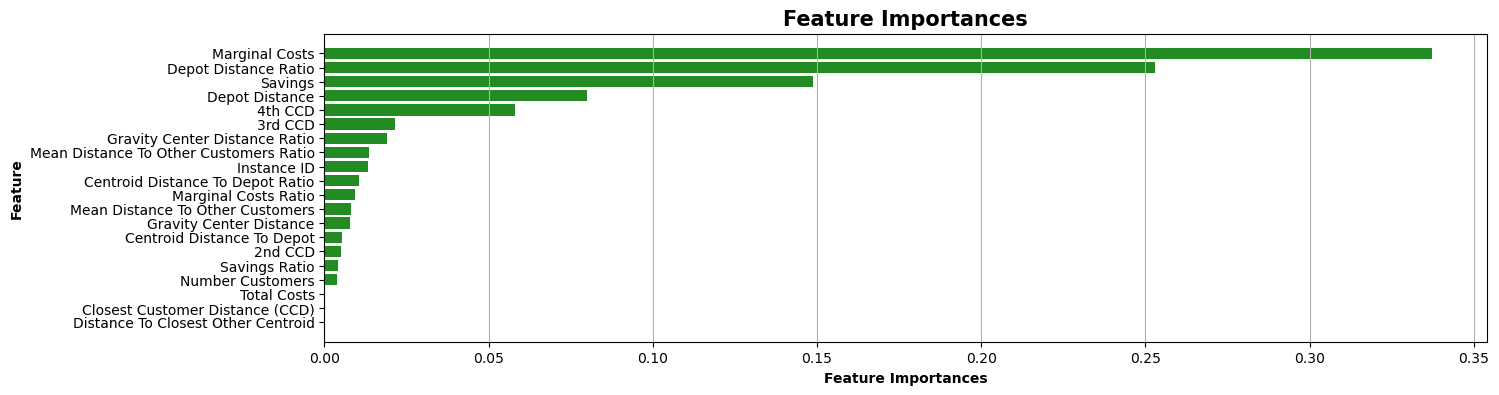

In [2]:
# Save best parameter combination
best_params_ = {'max_depth': 23,
                'max_features': 36,
                'max_leaf_nodes': 1359,
                'min_impurity_decrease': 0.00006018111448827135,
                'min_samples_leaf': 14}

# Train new model with best parameter combination and more trees
forest = RandomForestRegressor(n_estimators=200, **best_params_, #**random_grid_search.best_params_, # Or **best_params_
                               bootstrap=True, random_state=0, n_jobs=-1, verbose=False)

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=forest, X_train=X_train, y_train=y_train, cv=3)

# Save results to dictionary
results_dict['Random Forest (Best model, more trees)'] = model_results_dict

# View feature importances
plot_feature_weights(model=forest.fit(X_train, y_train), X_train=X_train, n_features=20)

### **2. Gradient Boosting Regression Trees**

In [3]:
if (optimization_problem == 'TSP'):

    # Randomized grid search cross validation
    param_distributions = {'n_estimators': range(50, 200), 
                        'learning_rate': uniform(0, 0.3), #lower learning rate requires more trees
                        'max_depth': range(1, 25),
                        'max_leaf_nodes': range(1200, 1700),
                        'min_samples_split': range(2, 20),
                        'min_samples_leaf': range(1, 25),
                        'max_features': Categorical(['auto', 'sqrt', 'log2', None])}

    random_grid_search = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=0, verbose=False), param_distributions=param_distributions, cv=3,
                                            n_iter=100, scoring='neg_mean_absolute_percentage_error',
                                            random_state=0, n_jobs=-1, verbose=False)
    fit_time = fun_fit_tuning(search_method=random_grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_GBRT_RGS_best_params.pkl')

    # View results of grid search cross validation
    model_results_dict = fun_scores(model=random_grid_search, X_train=X_train, y_train=y_train, cv=3)
    model_results_dict['Grid Search CV computation time'] = fit_time

    # Save results to dictionary
    results_dict['Gradient Boosting Regression Tree (RGS)'] = model_results_dict

    # View grid search CV scores of all parameter combinations
    results_df = fun_tuning_results(search_method=random_grid_search, search_space=param_distributions)

else: print('This cell is only executed for the TSP!')

  CV MAPE train data:  4.6959 %
  CV RMSE train data:  0.5396

  Best model / parameter combination:


{'learning_rate': 0.07782676930360648,
 'max_depth': 10,
 'max_features': 34,
 'max_leaf_nodes': 1207,
 'min_samples_leaf': 22,
 'min_samples_split': 7,
 'n_estimators': 186}

In [4]:
if (optimization_problem == 'TSP'):

    # Bayes search cross validation
    param_space = {'n_estimators': Integer(50, 200),
                'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
                'max_depth': Integer(3, 10),
                'max_leaf_nodes': Integer(1200, 1700),
                'min_samples_split': Integer(2, 20),
                'min_samples_leaf': Integer(1, 20),
                'subsample': Real(0.6, 1.0, prior='uniform'),
                'max_features': Categorical(['auto', 'sqrt', 'log2', None])}

    bayes_search = BayesSearchCV(GradientBoostingRegressor(random_state=0, verbose=False), param_space, n_iter=100, cv=3, 
                                scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=False)
    fit_time = fun_fit_tuning(search_method=bayes_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_GBRT_BS_best_params.pkl')

    # View results of grid search cross validation
    model_results_dict = fun_scores(model=bayes_search, X_train=X_train, y_train=y_train, cv=3)
    model_results_dict['Grid Search CV computation time'] = fit_time

    # Save results to dictionary
    results_dict['Gradient Boosting Regression Tree (Bayes)'] = model_results_dict

    # View grid search CV scores of all parameter combinations
    results_df = fun_tuning_results(search_method=bayes_search, search_space=param_space)

    # View feature importances
    plot_feature_weights(model=bayes_search.best_estimator_.fit(X_train, y_train), X_train=X_train, n_features=20)

else: print('This cell is only executed for the TSP!')

### **3. Extreme Gradient Boosting: XGBoost-Package**

In [ ]:
# Grid search cross validation
param_grid = {'n_estimators': [400, 500],
              'max_depth': [5, 7, 9],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0]}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_percentage_error', verbose=1, n_jobs=-1)
fit_time = fun_fit_tuning(search_method=grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_XGBOOST_GS_best_params.pkl')

# View results of grid search cross validation
model_results_dict = fun_scores(model=grid_search, X_train=X_train, y_train=y_train, cv=3)
model_results_dict['Grid Search CV computation time'] = fit_time

# Save results to dictionary
results_dict['XGBoost (GS)'] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=grid_search, search_space=param_grid)

# View feature importances
plot_feature_weights(model=bayes_search.best_estimator_.fit(X_train, y_train), X_train=X_train, n_features=20)

In [ ]:
# Bayes search cross validation
param_space = {'n_estimators': Integer(300, 500),
               'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
               'max_depth': Integer(3, 10),
               'min_child_weight': Integer(1, 10),
               'subsample': Real(0.4, 1.0, prior='uniform'),
               'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
               'gamma': Real(0.01, 7.0, prior='log-uniform'),
               'reg_alpha': Real(0.01, 1.0, prior='log-uniform'),
               'reg_lambda': Real(0.01, 1.0, prior='log-uniform')}

bayes_search = BayesSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_space, n_iter=5, cv=3, 
                             scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=False)
fit_time = fun_fit_tuning(search_method=bayes_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_XGBOOST_BS_best_params.pkl')

# View results of grid search cross validation
model_results_dict = fun_scores(model=bayes_search, X_train=X_train, y_train=y_train, cv=3)
model_results_dict['Grid Search CV computation time'] = fit_time

# Save results to dictionary
results_dict['XGBoost (Bayes)'] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=bayes_search, search_space=param_space)

# View feature importances
plot_feature_weights(model=bayes_search.best_estimator_.fit(X_train, y_train), X_train=X_train, n_features=20)

# **Compare Results**

In [ ]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))